# 5 Nonlinear Dynamics

So far we have only simulated linear models, which are of course only a small subset of all possible dynamic models. As you have seen in the lectures and tutorials, solving models can become much more complicated when non-linearities are involved, and is often restricted to local analyses of linearised systems around fixed points. Simulating non-linear models however is is not so different to simulating linear models. The only complication is that the fixed point problem that arises in implicit models may not always be straightforward to solve.

In this tutorial you will learn how to circumvent the problem of unsolvable fixed points and we apply it to the Crank-Nicolson method. Moreover, we will touch upon numerical methods to find fixed points of generic dynamic models using Newton's method.

In [116]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps

from matplotlib import rc
rc("text", usetex=True) # Latex font in figures

### 5.1 Solow model with constant technology and population

Consider Solow's growth model, defined by the following equations:

$\begin{align}
    Y &= AK^{\alpha}L^{(1-\alpha)} \hspace{0.1cm};\hspace{0.5cm}0<\alpha<1\\
    Y &= C + I \\
    S &= sY = I\\
    K' &= I - \gamma K = sY
\end{align}$

The first equation is a standard Cobb-Douglas production function with technology parameter $A$, capital input $K$, and labour input $L$, which defines the total output $Y$. The second equation states that all produciton is either consumed or invested, and the third equation is the savings-investment identity $S=I$. Note that a fixed share of total income $s$ is saved in every period. Finally, The law of motion states that the rate of change of capital equals investments (positive inflow to capital) minus depreciation (outflow form capital, through wear-and-tear or similar), which is a linear function of capital with the depreciation rate $\gamma$.

In per-capita terms, the last equation can be restated as

$\begin{equation}
    k' = sk^{\alpha} - \gamma k
\end{equation}$

Solving the fixed-point problem of the implicit Crank-Nicolson method to iterate this equation forward in time would be cumbersome at best. Instead, we will approximate $k_{t+\delta}$ with an explicit Euler step, and calculate the rate of change at this point, so we can use it in our Crank-Nicolson scheme. This is not as accurate as the analytical solution, but still improves a lot on the explicit Euler scheme applied by itself.

##### EXERCISE

Implement a single step of the Crank-Nicolson method in the function below. As explained above, estimate $k_{t+\delta}$ with an explicit Euler step and then calculate the derivates at $k_t$ and $k_{t+\delta}$ to perform the step forward. 

Write a separate function for the Euler step. That way, we can compare behaviour of both methods afterwards, and your code becomes more readable. Generally, it is a good idea to split functions into subroutines, so that each function has narrow and focused responsibilities.

##### SOLUTION

Recall the Crank-Nicolson method: $k_{t+\delta} \approx k_t + \frac{\delta}{2}(k'_t + k'_{t+\delta}$. Inserting the derivatives would yield the equation

$\begin{equation}
    (1+\delta\gamma)k_{t+\delta} - \delta sk_{t+\delta}^{\alpha} = (1- \delta\gamma)k_t
\end{equation}$

which we do not want to solve by hand. Instead, we estimate $k'_{t+\delta}$ with an explicit Euler step and approximate the derivative at this point: 

$\begin{align}
    \tilde{k}_{t+\delta} &\approx k_t + \delta(sk^{\alpha} - \gamma k)\\
    \tilde{k'}_{t+\delta} &\approx s\tilde{k}_{t+\delta}^{\alpha} - \gamma\tilde{k}_{t+\delta}
\end{align}$ 

Finally, we use the derivatives at both points to implement the time step:

$\begin{equation}
    k_{t+\delta} \approx k_t + \frac{\delta}{2}(k'_t + \tilde{k'}_{t+\delta})
\end{equation}$

In [2]:
# separate function to calculate the derivative
def solow_derivative(k, alpha, s, gamma):
    return s * k**alpha - gamma * k

# euler step
def ee_solow_step(k, alpha, s, gamma, delta):
    return k + delta * solow_derivative(k, alpha, s, gamma)

# crank-nicolson
def cn_solow_step(k, alpha, s, gamma, delta):
    # euler step to approximate k one step further 
    k_tilde = ee_solow_step(k, alpha, s, gamma, delta)
    # derivatives
    d1 = solow_derivative(k, alpha, s, gamma)
    d2 = solow_derivative(k_tilde, alpha, s, gamma)
    # cn-step, return right away
    return k + (delta / 2) * (d1 + d2)

##### Exercise

Implement the function that simulates Solow's model with either of the two timestepping functions!

Inputs are the standard model parameters, the time increment $\delta$, as well as the total number of *unit* time steps `T` and the timestepping function. Output should be a numpy array of capital values $k$.

In [3]:
def simulate_Solow(k_0, alpha, s, gamma, delta, T, timestep_func):
    # total number of time increments: inverse of increment times unit steps
    T = int(T/delta)
    
    # time series of capital, as an array
    k_ts = np.empty(T+1)
    k_ts[0] = k_0
    
    for t in range(T):
        # new value k
        k_new = timestep_func(k_ts[t], alpha, s, gamma, delta)
        # insert into array
        k_ts[t+1] = k_new
        # both steps could be performed in one line:
        # k_ts[t+1] = timestep_fun(k_ts[t], alpha, s, gamma, delta)
        
    return k_ts

In [14]:
# set variable values
delta = 1/16 # time increment
T = 75        # time unit steps
alpha = 1/3   # Cobb-Douglas exponent
gamma = 0.1   # depreciation rate of capital
s = 0.1       # savings rate
k_0 = 0.1     # initial capital

Solow_T_CN = simulate_Solow(k_0, alpha, s, gamma, delta, T, cn_solow_step)

<IPython.core.display.Javascript object>


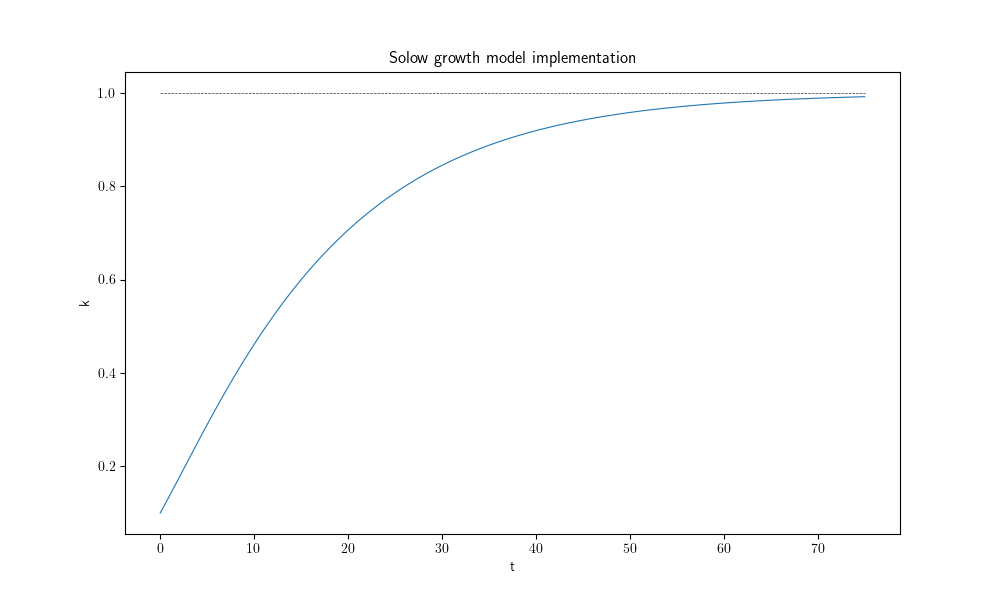

Text(0, 0.5, 'k')

In [15]:
plt.figure(figsize=(10,6))
plt.title('Solow growth model implementation')

# x-axis re-adjusted
t = np.linspace(0, T, int(T/delta)+1)
# plot the time series
plt.plot(t, Solow_T_CN, lw=0.8)

# analytical solution of the steady state:
ss = (s / gamma) ** (1 / (1-alpha))
# horizontal line at steady state
plt.hlines(ss, 0, T, ls='--', lw=0.5, color="black", alpha=0.8)

# axis labels
plt.xlabel("t")
plt.ylabel("k")

##### Bonus exercise

Implement the logistic growth function $x' = rx(1-x)$ using the Crank-Nicolson method!

### Systems of non-linear equations

Consider the system of Tutorial 5, exercise 1:

$\begin{align}
    z_1' &= z_2(z_1 + 1)\\
    z_2' &= z_1(z_2 + 3)
\end{align}$

Implementing simulation methods for systems of non-linear equations should bring no surprises to you: instead of calculating the derivative for one variable, we calculate the derivatives of all state variables, and increment all variables according to their law of motion.

##### EXERCISE
Write three separate functions:
* one that takes the current state vector (numpy array) as input and returns the derivative at that point (also as a numpy array)
* one that implements a single explicit Euler step
* and finally, one that implements a single Crank-Nicolson step

##### SOLUTION

In [16]:
def derivative(z):
    dz1 = z[1] * (z[0] + 1)
    dz2 = z[0] * (z[1] + 3)
    return np.array([dz1, dz2])

def ee_step(z, delta):
    return z + delta * derivative(z)

def cn_step(z, delta):
    z_tilde = ee_step(z, delta)
    return z + 0.5 * delta * (derivative(z) + derivative(z_tilde))

Finally, we can simulate this system too.  Let's try different initial conditions to see how it does not always reach the same steady state:

In [90]:
delta = 1/2014         # time increment

# two different time lengths for stable and unstable starting positions (for plotting purposes)
T_stable = 2
T_unstable = 1

# different initial conditions
# stable
za = np.array([1, -2]) 
zb = np.array([-4, -4])
zc = np.array([-0.75, 2])
# unstable
zd = np.array([2, -1.52])
ze = np.array([-0.5, 2])

z1 = np.empty((2,int(T_stable/delta) + 1))
z1[:, 0] = za

z2 = np.empty((2,int(T_stable/delta) + 1))
z2[:, 0] = zb

z3 = np.empty((2,int(T_stable/delta) + 1))
z3[:, 0] = zc

z4 = np.empty((2,int(T_unstable/delta) + 1))
z4[:, 0] = zd

z5 = np.empty((2,int(T_unstable/delta) + 1))
z5[:, 0] = ze

U_stable = int(T_stable/delta)
U_unstable = int(T_unstable/delta)

for u in range(U_stable):
    z1[:, u+1] = cn_step(z1[:, u], delta)
    z2[:, u+1] = cn_step(z2[:, u], delta)
    z3[:, u+1] = cn_step(z3[:, u], delta)
    
for u in range(U_unstable):
    z4[:, u+1] = cn_step(z4[:, u], delta)
    z5[:, u+1] = cn_step(z5[:, u], delta)

<IPython.core.display.Javascript object>


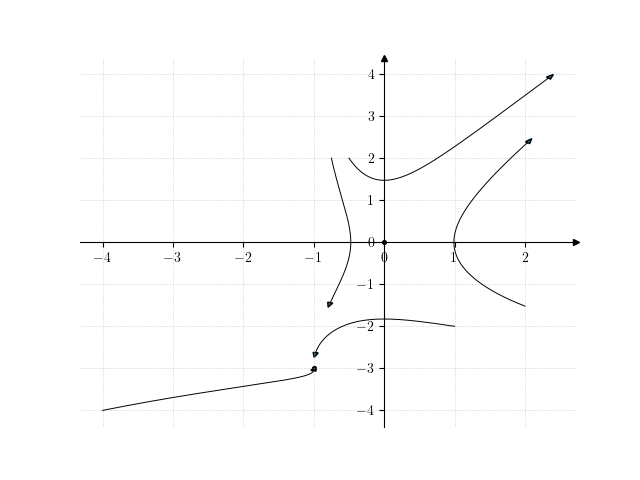

In [95]:
plt.figure()

for z in [z1, z2, z3, z4, z5]:
    plt.plot(z[0], z[1], lw=0.7, c='black')
    # add arrow heads
    dz1 = z[0,-1] - z[0,-2]
    dz2 = z[1, -1] - z[1, -2]
    plt.arrow(z[0,-2], z[1, -2], dz1, dz2, head_width=0.075)

# steady states
plt.scatter([0, -1],[0, -3], s=7, c='black')

# give the figure a more "mathy" feel by removing the top and left spines, 
# add arrowheads to the others
ax = plt.gca()
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
arrow_fmt = dict(markersize=4, color='black', clip_on=False)
ax.plot((1), (0), marker='>', transform=ax.get_yaxis_transform(), **arrow_fmt)
ax.plot((0), (1), marker='^', transform=ax.get_xaxis_transform(), **arrow_fmt)

plt.grid(ls=':', lw=0.4)

This figure shows the saddle stability of the steady state in the origin quite nicely. 

A good alternative to phase diagrams for non-linear systems are gradient fields. Those draw little arrows at discrete points of the grid, representing the direction the system takes if it starts from there. Find an implementation using the derivatives function below.

In [151]:
# gridpoints on both axes
z1_ax = np.linspace(-3, 2, 20)
z2_ax = np.linspace(-4, 3, 20)

# create a 3d grid: one dimension for each axis
# 1 dimension because derivatives come in two values (dz1, dz2)
grid = np.empty((2, len(z1_ax), len(z2_ax)))

# fill grid
for i, z1_ in enumerate(z1_ax):
    for j, z2_ in enumerate(z2_ax):
        grid[:,i,j] = derivative(np.array([z1_, z2_]))
        
# colours will be based on magnitude of change
# create a grid with deriuvatives where total change is scaled between 0 and 1
col_grid = np.empty((len(z1_ax), len(z2_ax)))
for i in range(len(z1_ax)):
    for j in range(len(z2_ax)):
        col_grid[i,j] = np.sqrt(grid[0,i,j]**2 + grid[1,i,j]**2)
# scaling
col_grid = (col_grid - col_grid.min()) / (col_grid.max() - col_grid.min())
col_grid.min()

0.0

<IPython.core.display.Javascript object>


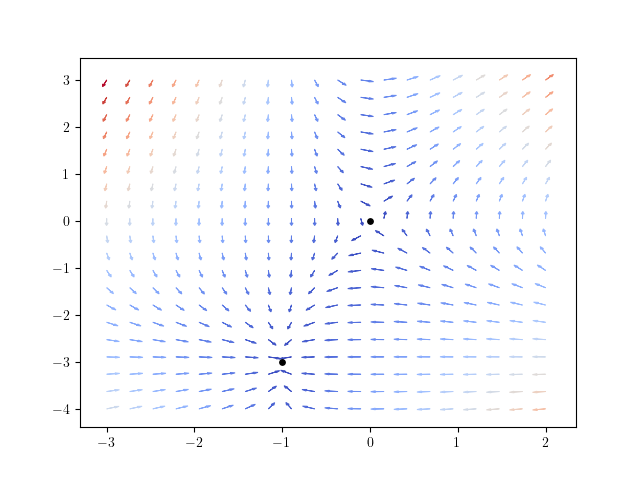

In [158]:
plt.figure()

cmap = colormaps['coolwarm']

for i, z1_ in enumerate(z1_ax):
    for j, z2_ in enumerate(z2_ax):
        dz1, dz2 = grid[:, i, j]
        # scale the length of the arrow
        length = np.sqrt(dz1**2 + dz2**2)
        dz1_scaled = 0.15 * dz1 / length
        dz2_scaled = 0.15 * dz2 / length
        
        # color according to the magnitude of change
        col = cmap(col_grid[i,j])

        plt.arrow(
            z1_, z2_, dz1_scaled, dz2_scaled, 
            color=col, lw=0.7, head_width=0.035, length_includes_head=True
        )

# steady states
plt.scatter([0, -1],[0, -3], s=15, c='black')

In [ ]:
### Finding fixed points